In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#import seaborn as sns
#sns.set()
import copy
from evaluation import * #some visualization functions
import tensorflow as tf
#from astroML.decorators import pickle_results
%config InlineBackend.figure_format='retina'

# import RFR
from sklearn.ensemble import RandomForestRegressor

In [2]:
cols=['dered_u','dered_g','dered_r','dered_i','dered_z','dered_color_ug','dered_color_gr','dered_color_ri','dered_color_iz','dered_frac_uz','C']

In [3]:
#large dataset, don't grab all of it, only use columns we care about
X = pd.read_csv('SDSS_DR12_awe2_0.csv', usecols=cols)
#targets
Y = pd.read_csv('SDSS_DR12_awe2_0.csv',usecols=['z'])

In [4]:
X.head

<bound method NDFrame.head of          dered_u   dered_g   dered_r   dered_i   dered_z  dered_color_ug  \
0       20.07695  18.21239  17.23913  16.82238  16.49874        1.864559   
1       18.76690  17.66344  17.22466  16.92888  16.84306        1.103458   
2       19.78869  18.18713  17.25847  16.89089  16.60906        1.601561   
3       18.42462  16.54012  15.65375  15.23006  14.89166        1.884495   
4       19.67483  18.07697  17.21868  16.78680  16.42058        1.597860   
5       17.36523  15.98793  15.28494  14.91373  14.62035        1.377295   
6       21.25202  19.19077  17.80368  17.32270  16.95649        2.061255   
7       17.14297  15.60896  14.86385  14.48673  14.18842        1.534006   
8       18.78443  17.73384  17.25562  16.93244  16.73932        1.050587   
9       18.82480  17.19655  16.44800  16.10164  15.83562        1.628244   
10      15.28607  13.54344  12.72825  12.29586  11.99509        1.742630   
11      21.72010  20.79535  20.26194  20.01633  19.87787  

In [5]:
data = pd.read_csv("SDSS_DR12_awe2_0.csv",index_col=0,
                   usecols=["specObjID",'dered_u','dered_g','dered_r','dered_i','dered_z','dered_color_ug','dered_color_gr','dered_color_ri','dered_color_iz','dered_frac_uz','C','z'])

#when I made this dataset I grabbed alot of sparse region data.
#Lets get back to a region where we have enough examples
data = data[data['z'] <= 0.4]

# Response variables: redshift
data_redshifts = data['z']

# Features or attributes: photometric measurements
data_features = copy.copy(data)
del data_features['z']
data_features.head()

,dered_u,dered_g,dered_r,dered_i,dered_z,dered_color_ug,dered_color_gr,dered_color_ri,dered_color_iz,dered_frac_uz,C
specObjID,,,,,,,,,,,
345721668045400064,20.07695,18.21239,17.23913,16.82238,16.49874,1.864559,0.973261,0.416756,0.323633,1.216878,2.958234
345689782208194560,18.76690,17.66344,17.22466,16.92888,16.84306,1.103458,0.438782,0.295778,0.085827,1.114222,1.990836
529188106864191488,19.78869,18.18713,17.25847,16.89089,16.60906,1.601561,0.928652,0.367588,0.281828,1.191439,2.673254
531462996858267648,18.42462,16.54012,15.65375,15.23006,14.89166,1.884495,0.886367,0.423692,0.338399,1.237244,3.322546
535942963008661504,19.67483,18.07697,17.21868,16.78680,16.42058,1.597860,0.858295,0.431875,0.366219,1.198181,2.325654


In [6]:
#split into train, val, test as other group members!
mag_train = data_features.iloc[0:175000].values #175000 train
z_train = data_redshifts.iloc[0:175000].values

x_val = data_features.iloc[175000:300000].values #125000 val
y_val_examine = data_redshifts.iloc[175000:300000].values
y_val = tf.keras.utils.to_categorical(np.round((180-1)*(data_redshifts.iloc[175000:300000]/0.4),0).astype(int))

mag_test = data_features.iloc[300000::].values #~200000 test
z_test = data_redshifts.iloc[300000::].values

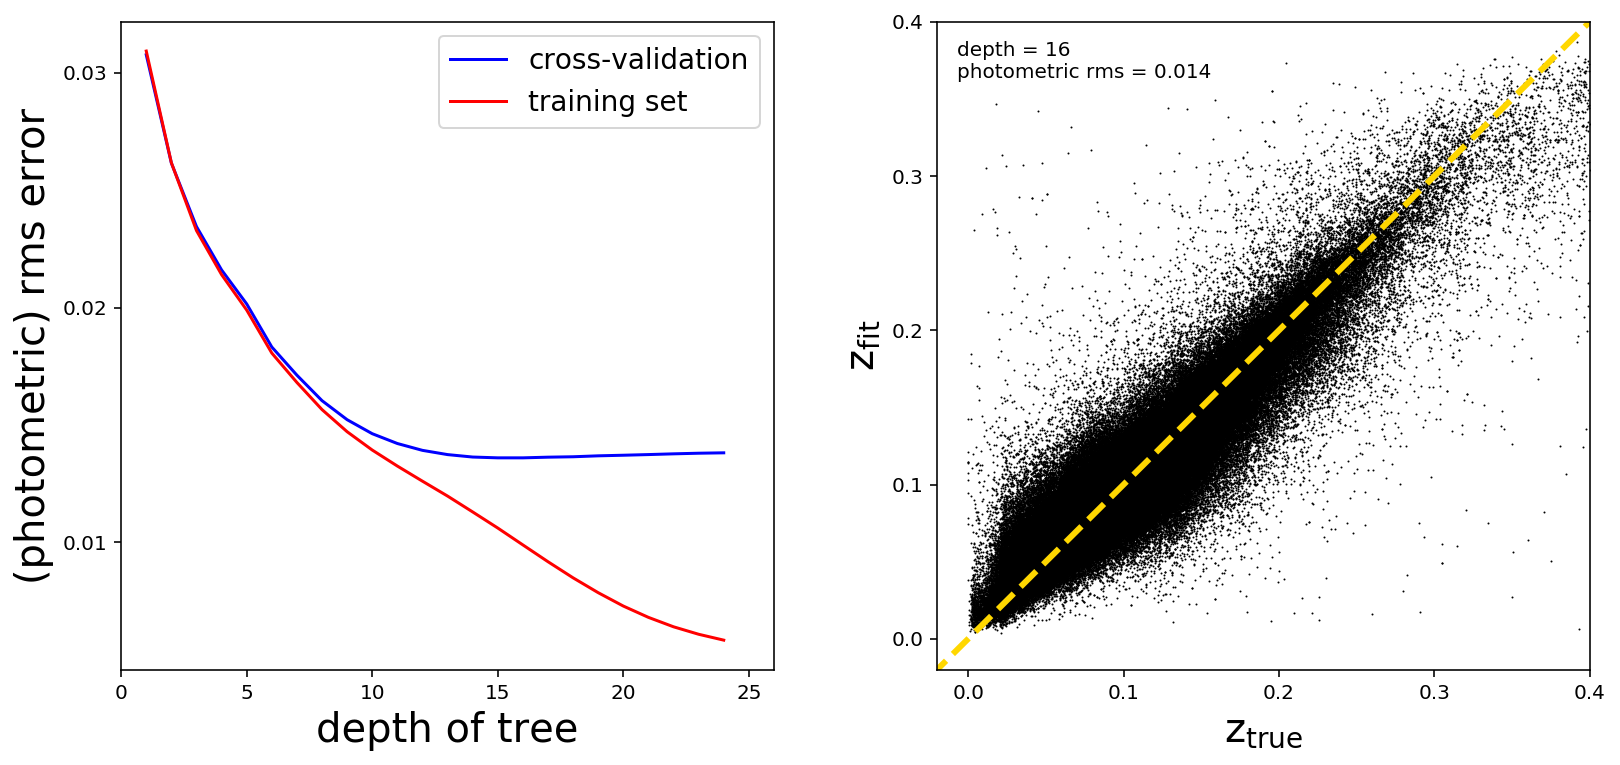

In [7]:
#------------------------------------------------------------
# Compute the results
#  This is a long computation, so we'll save the results to a pickle.
#@pickle_results('photoz_forest.pkl')
def compute_photoz_forest(depth):
    rms_test = np.zeros(len(depth))
    rms_train = np.zeros(len(depth))
    i_best = 0
    z_fit_best = None

    for i, d in enumerate(depth):
        
        ### YOU CAN CHANGE N_ESTIMATORS IF YOU LIKE 
        clf = RandomForestRegressor(n_estimators=10,
                                    max_depth=d, random_state=0)
        clf.fit(mag_train, z_train)

        z_fit_train = clf.predict(mag_train)
        z_fit = clf.predict(mag_test)
        rms_train[i] = np.mean(np.sqrt(((z_fit_train - z_train)/(1+z_fit_train)) ** 2))
        rms_test[i] = np.mean(np.sqrt(((z_fit - z_test)/(1+z_fit)) ** 2))

        if rms_test[i] <= rms_test[i_best]:
            i_best = i
            z_fit_best = z_fit

    return rms_test, rms_train, i_best, z_fit_best, clf

depth = np.arange(1, 25)
rms_test, rms_train, i_best, z_fit_best, clf = compute_photoz_forest(depth)
best_depth = depth[i_best]

#------------------------------------------------------------
# Plot the results
fig = plt.figure(figsize=(12, 6))
fig.subplots_adjust(wspace=0.25,
                    left=0.1, right=0.95,
                    bottom=0.15, top=0.9)

# left panel: plot cross-validation results
ax = fig.add_subplot(121)
ax.plot(depth, rms_test, 'blue', label='cross-validation')
ax.plot(depth, rms_train, 'red', label='training set')
ax.legend(loc=1, prop=dict(size=14))

ax.set_xlabel('depth of tree', fontsize=20)
ax.set_ylabel('(photometric) rms error', fontsize=20)

ax.set_xlim(0, 26)
#ax.set_ylim(0.009,  0.04)
ax.yaxis.set_major_locator(plt.MultipleLocator(0.01))

# right panel: plot best fit
ax = fig.add_subplot(122)
ax.scatter(z_test, z_fit_best, s=1, lw=0, c='k')
ax.plot([-0.1, 0.4], [-0.1, 0.4], ls='--', lw=3, c='gold')
ax.text(0.03, 0.97, "depth = %i\nphotometric rms = %.3f" % (best_depth, rms_test[i_best]),
        ha='left', va='top', transform=ax.transAxes)

ax.set_xlabel(r'$\rm z_{true}$', fontsize=20)
ax.set_ylabel(r'$\rm z_{fit}$', fontsize=20)

ax.set_xlim(-0.02, 0.4001)
ax.set_ylim(-0.02, 0.4001)
ax.xaxis.set_major_locator(plt.MultipleLocator(0.1))
ax.yaxis.set_major_locator(plt.MultipleLocator(0.1))

plt.show()

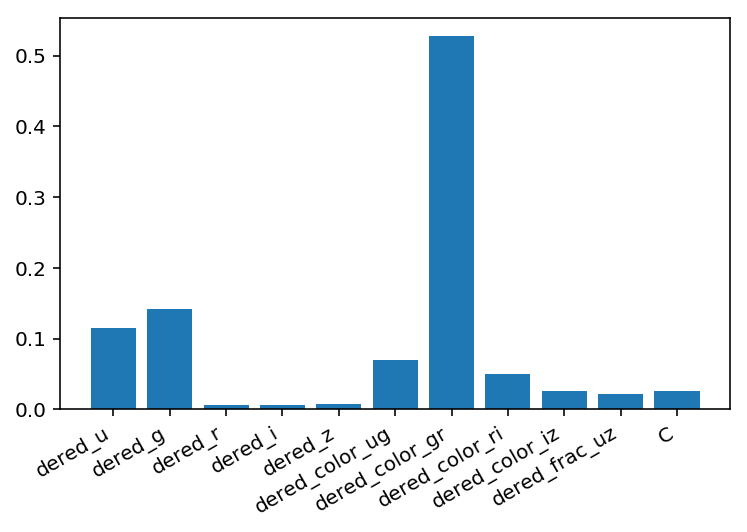

In [8]:
n_features = len(data_features.columns)
plt.bar(range(n_features), clf.feature_importances_ )
ax = plt.gca()
ax.set_xticks(range(n_features))
ax.set_xticklabels(list(data_features.columns))
fig = plt.gcf()
fig.autofmt_xdate()

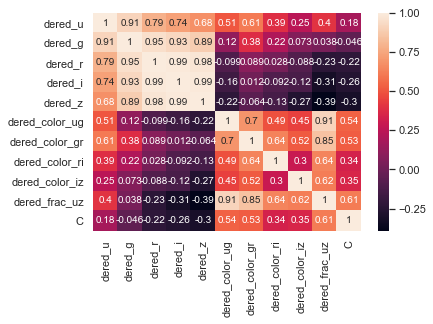

In [59]:
# AND THIS
corrMatrix = data_features.corr()
sns.heatmap(corrMatrix, annot=True)
plt.show()

In [9]:
#y_pred = mymodel.predict(x_val)
y_pred = clf.predict(x_val)

In [10]:
NB_BINS = 60 * 3
BATCH_SIZE = 32
ZMIN = 0.0
ZMAX = 0.4
BIN_SIZE = (ZMAX - ZMIN) / NB_BINS
range_z = np.linspace(ZMIN, ZMAX, NB_BINS + 1)[:NB_BINS]

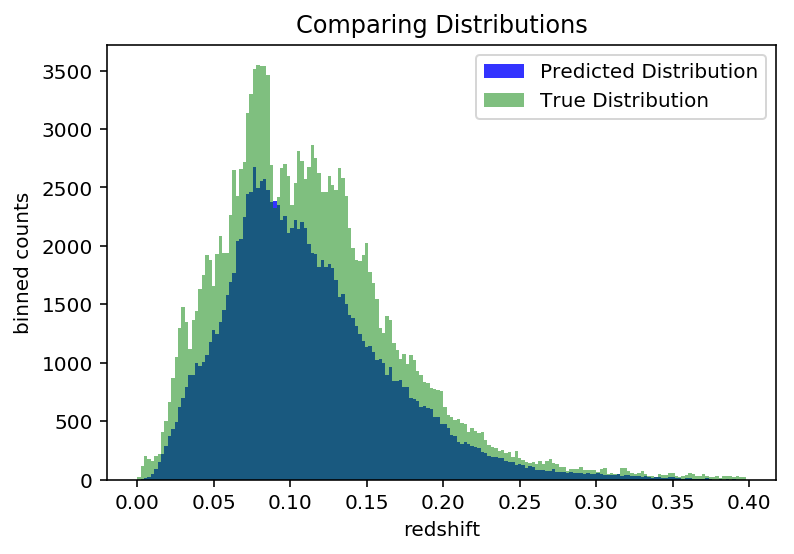

In [14]:
plt.title('Comparing Distributions')
plt.hist(y_pred,bins=range_z, color='b', label = 'Predicted Distribution', alpha=0.8) #for regression
plt.hist(z_train,bins=range_z, color='g', label = 'True Distribution', alpha=0.5)
plt.xlabel('redshift')
plt.ylabel('binned counts')
plt.legend()
plt.show()

MAD:  0.0147
bias:  -0.0009
outlier_fraction_eta pasquet:  0.0025
RMS:  0.0199
outlier fraction LSST:  0.0155


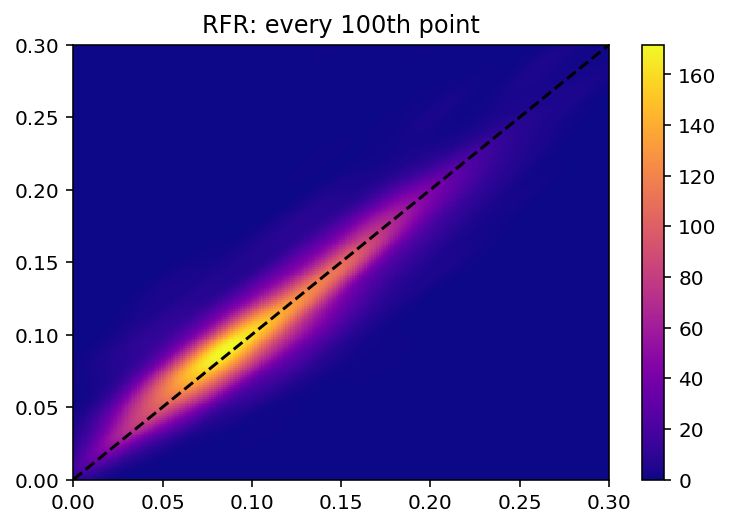

In [15]:
from scipy.stats import kde
x=y_val_examine
#y=np.sum(range_z*y_pred,1) #for categorical
y=y_pred #for regression


#CRPS, FOR CLASS ONLY:
#z_bins = np.argmax(y_val,axis=1)
#CRPS=np.zeros(len(y_val))
#for i in range(len(CRPS)):
#    CRPS[i] = (np.sum((np.cumsum(y_pred[i,0:z_bins[i]]))**2) + np.sum((np.cumsum(y_pred[i,z_bins[i]::])-1)**2)) * BIN_SIZE
#print(np.shape(CRPS))
#CRPS_estimator=np.mean(CRPS)

#summary stats
residuals = (x-y)/(1+x)
bias = np.mean(residuals)
MAD = 1.4826*np.median(abs(residuals - np.median(residuals)))
outlier_fraction_eta = len(residuals[residuals > 5*MAD])/len(residuals)
eta_LSST = len(residuals[residuals > 3*MAD*(1+residuals)])/len(residuals)
RMS = np.sqrt(np.mean(np.square(residuals)))
#print('CRPS: ',round(CRPS_estimator,4))
print('MAD: ',round(MAD,4))
print('bias: ',round(bias,4))
print('outlier_fraction_eta pasquet: ',round(outlier_fraction_eta,4))
print('RMS: ',round(RMS,4))
print('outlier fraction LSST: ',round(eta_LSST,4))
#KDE plot
nbins=300
x=x[::100]
y=y[::100]

k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[0:0.4:nbins*1j, 0:0.4:nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))
 
# Make the plot
plt.pcolormesh(xi, yi, zi.reshape(xi.shape), cmap='plasma')
plt.plot([0,1],[0,1],'k--')
plt.xlim(0,0.3)
plt.ylim(0,0.3)
plt.title('RFR: every 100th point')
plt.colorbar()
plt.show()

#PIT(y_val_examine,y_pred,'RFR PIT')
